In [111]:
import torch

# Define the Python function for f1 and f2 as provided in the image
def f1(x):
    # Squeeze the middle dimension to make sure we have a m*4 tensor
    x_squeezed = 2*x.squeeze(1)-1
    return -3.95 + 9.20 * torch.sigmoid(-0.32 + 5.06*x_squeezed[:,0] - 4.07*x_squeezed[:,1] - 0.36*x_squeezed[:,2] - 0.34*x_squeezed[:,3]) + \
           9.88 * torch.sigmoid(-4.83 + 7.43*x_squeezed[:,0] + 3.46*x_squeezed[:,1] + 9.19*x_squeezed[:,2] + 16.58*x_squeezed[:,3]) + \
           10.84 * torch.sigmoid(-7.90 - 7.91*x_squeezed[:,0] - 4.48*x_squeezed[:,1] - 4.08*x_squeezed[:,2] - 8.28*x_squeezed[:,3]) + \
           15.18 * torch.sigmoid(-9.41 - 7.99*x_squeezed[:,0] + 0.65*x_squeezed[:,1] + 3.14*x_squeezed[:,2] + 0.31*x_squeezed[:,3])

def f2(x):
    # Squeeze the middle dimension to make sure we have a m*4 tensor
    x_squeezed = 2*x.squeeze(1)-1
    return 1.07 + 0.62 * torch.sigmoid(-3.05 + 0.03*x_squeezed[:,0] + 0.16*x_squeezed[:,1] + 4.03*x_squeezed[:,2] - 0.54*x_squeezed[:,3]) + \
           0.65 * torch.sigmoid(-1.78 + 0.60*x_squeezed[:,0] - 3.19*x_squeezed[:,1] + 0.10*x_squeezed[:,2] + 0.54*x_squeezed[:,3]) - \
           0.72 * torch.sigmoid(-0.01 + 2.04*x_squeezed[:,0] - 3.73*x_squeezed[:,1] + 0.10*x_squeezed[:,2] - 1.05*x_squeezed[:,3]) - \
           0.45 * torch.sigmoid(-1.82 + 4.78*x_squeezed[:,0] + 0.48*x_squeezed[:,1] - 4.68*x_squeezed[:,2] - 1.65*x_squeezed[:,3]) - \
           0.32 * torch.sigmoid(-2.69 + 5.99*x_squeezed[:,0] + 3.87*x_squeezed[:,1] + 3.10*x_squeezed[:,2] - 2.17*x_squeezed[:,3])

# Define the combined function f3
def objective(x):
    # Calculate f3 using f1 and f2
    return ((60 - f1(x)) / 60) * (f2(x) / 1.5)

In [113]:
# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set default tensor type to float64
torch.set_default_dtype(torch.float64)

In [8]:
import gpytorch
from torch import Tensor

from botorch.models import FixedNoiseGP
from botorch.models.transforms import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model

In [9]:
def fit_gp_model(X, Y, Yvar=None):
    if X.ndim == 1:
        X = X.unsqueeze(dim=-1)
    if Y.ndim == 1:
        Y = Y.unsqueeze(dim=-1)
    model = FixedNoiseGP(X, Y, torch.ones(Y.shape) * 1e-4, outcome_transform=Standardize(m=Y.shape[-1]))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    return model

In [10]:
from torch.autograd import (Function, grad)
from botorch.acquisition import AnalyticAcquisitionFunction
from botorch.models.model import Model
from botorch.acquisition.analytic import (_scaled_improvement, _ei_helper)
from botorch.acquisition.objective import PosteriorTransform
from typing import Dict, Optional, Tuple, Union
from botorch.utils.transforms import t_batch_mode_transform
from botorch.utils.probability.utils import (
    ndtr as Phi,
    phi,
)

In [57]:
class GittinsIndexFunction(Function):
    @staticmethod
    def forward(X: torch.Tensor, mean: torch.Tensor, sigma: torch.Tensor, cost: float, maximize: bool, bounds: torch.Tensor, eps: float):
        
        def cost_adjusted_expected_improvement(best_f):
            u = _scaled_improvement(mean, sigma, best_f, maximize)
            return sigma * _ei_helper(u) - cost

        size = X.size()[0]
        l = bounds[0]*torch.ones(size)
        h = bounds[1]*torch.ones(size)
        m = (h + l) / 2

        if maximize:
            while torch.any(cost_adjusted_expected_improvement(best_f=l) < 0):
                l = 2 * l
            while torch.any(cost_adjusted_expected_improvement(best_f=h) > 0):
                h = 2 * h
        else:
            while torch.any(cost_adjusted_expected_improvement(best_f=l) > 0):
                l = 2 * l
            while torch.any(cost_adjusted_expected_improvement(best_f=h) < 0):
                h = 2 * h

        # Bisection method
#         while torch.max(torch.abs(cost_adjusted_expected_improvement(best_f=m))) >= eps:
        for _ in range(100):
            sgn_m = torch.sign(cost_adjusted_expected_improvement(best_f=m))
            if maximize:
                l = torch.where(sgn_m >= 0, m, l)
                h = torch.where(sgn_m <= 0, m, h)
            else:
                l = torch.where(sgn_m <= 0, m, l)
                h = torch.where(sgn_m >= 0, m, h)
            m = (h + l) / 2
            
        return m
    
    @staticmethod
    def setup_context(ctx, inputs, output):
        X, mean, sigma, cost, maximize, bounds, eps = inputs
        
        # Save u for backward computation
        u = _scaled_improvement(mean, sigma, output, maximize)
        
        # Save values needed in the backward pass
        ctx.save_for_backward(X, mean, sigma, u)
        
        # Save boolean flag directly in ctx
        ctx.maximize = maximize  

    @staticmethod
    def backward(ctx, grad_output):
                
        # Retrieve saved tensors
        X, mean, sigma, u = ctx.saved_tensors
        maximize = ctx.maximize  # Retrieve the boolean flag directly from ctx
                
        # Gradient of mean function with respect to x
        dmean_dX = grad(outputs=mean, inputs=X, grad_outputs=torch.ones_like(mean), retain_graph=True, allow_unused=True)[0].clone()

        # Gradient of the std function with respect to x
        dsigma_dX = grad(outputs=sigma, inputs=X, grad_outputs=torch.ones_like(sigma), retain_graph=True, allow_unused=True)[0].clone()
        
        # Check if gradients are None and handle accordingly
        if dmean_dX is None or dsigma_dX is None:
            raise RuntimeError("Gradients could not be computed for one or more components.")
        
        # Compute the gradient of the Gittins acquisition function
        if maximize:
            grad_X = grad_output.unsqueeze(-1).unsqueeze(-1) * (dmean_dX + phi(u).unsqueeze(-1).unsqueeze(-1) * dsigma_dX / Phi(u).unsqueeze(-1).unsqueeze(-1))
        else:
            grad_X = grad_output.unsqueeze(-1).unsqueeze(-1) * (dmean_dX - phi(u).unsqueeze(-1).unsqueeze(-1) * dsigma_dX / Phi(u).unsqueeze(-1).unsqueeze(-1))

        return grad_X, None, None, None, None, None, None

In [12]:
class GittinsIndex(AnalyticAcquisitionFunction):
    r"""Single-outcome Gittins Index (analytic).

    Computes Gittins index using the analytic formula for a Normal posterior distribution. Unlike the
    MC-based acquisition functions, this relies on the posterior at single test
    point being Gaussian (and require the posterior to implement `mean` and
    `variance` properties). Only supports the case of `q=1`. The model must be
    single-outcome.

    `GI(x) = argmin_g |E(max(f(x) - g, 0))-cost|,`

    where the expectation is taken over the value of stochastic function `f` at `x`.

    Example:
        >>> model = SingleTaskGP(train_X, train_Y)
        >>> GI = GittinsIndex(model, cost=0.05)
        >>> gi = GI(test_X)
        
    """

    def __init__(
        self,
        model: Model,
        cost: float,
        posterior_transform: Optional[PosteriorTransform] = None,
        maximize: bool = True,
        bounds: torch.Tensor = torch.tensor([[-1.0], [1.0]], dtype=torch.float64),
        eps: float = 1e-6
    ):
        r"""Single-outcome Gittins Index (analytic).
        
        Args:
            model: A fitted single-outcome model.
            cost: Either a scalar or a `b`-dim Tensor (batch mode) representing
                the cost function.
            posterior_transform: A PosteriorTransform. If using a multi-output model,
                a PosteriorTransform that transforms the multi-output posterior into a
                single-output posterior is required.
            maximize: If True, consider the problem a maximization problem.
            bounds: A `2 x d` tensor of lower and upper bounds for each column of `X`.
        """
        super().__init__(model=model, posterior_transform=posterior_transform)
        self.cost = cost
        self.maximize = maximize
        self.bounds = bounds
        self.eps = eps
      
        
    @t_batch_mode_transform(expected_q=1)
    def forward(self, X: Tensor) -> Tensor:
        r"""Evaluate Gittins Index on the candidate set X using bisection method.

        Args:
            X: A `(b1 x ... bk) x 1 x d`-dim batched tensor of `d`-dim design points.
                Gittins Index is computed for each point individually,
                i.e., what is considered are the marginal posteriors, not the joint.

        Returns:
            A `(b1 x ... bk)`-dim tensor of Gittins Index values at the
            given design points `X`.
        """
        
        mean, sigma = self._mean_and_sigma(X)
#         mean = self.model.posterior(X).mean.squeeze(-2).squeeze(-1)
#         sigma = self.model.posterior(X).variance.sqrt().squeeze(-2).squeeze(-1)
            
        return GittinsIndexFunction.apply(X, mean, sigma, self.cost, self.maximize, self.bounds, self.eps)

In [107]:
from botorch.models.transforms.outcome import Standardize
from botorch.utils.sampling import draw_sobol_samples

seed = 42

maximize = True 

num_iterations = 40

torch.manual_seed(seed)

# Specify the number of dimensions
d = 4  # You can change this to any number of dimensions you need

# Define the bounds of your d-dimensional hypercube
lower_bounds = torch.zeros(d)
upper_bounds = torch.ones(d)

# Define the bounds of your cube (e.g., a unit cube in 3D space)
bounds = torch.stack([lower_bounds, upper_bounds])

# Number of points to sample
n_points = 2*d+1

# Generate points using Sobol sequences
x = draw_sobol_samples(bounds=bounds, n=1, q=n_points, seed=seed).squeeze(0).requires_grad_(True)
y = objective(x).unsqueeze(-1)  # add output dimension

In [108]:
x

tensor([[0.9975, 0.1044, 0.8230, 0.4194],
        [0.5283, 0.0562, 0.4553, 0.7492],
        [0.2211, 0.6177, 0.8101, 0.2123],
        [0.0384, 0.8818, 0.6506, 0.6666],
        [0.8209, 0.5966, 0.2363, 0.8070],
        [0.1671, 0.7678, 0.6035, 0.9326],
        [0.5377, 0.3988, 0.3613, 0.2897],
        [0.6536, 0.2348, 0.3760, 0.3226],
        [0.9922, 0.3485, 0.0177, 0.3184]], requires_grad=True)

In [109]:
y

tensor([[0.2917],
        [0.3689],
        [0.6109],
        [0.6072],
        [0.2552],
        [0.5896],
        [0.3070],
        [0.2237],
        [0.0050]], grad_fn=<UnsqueezeBackward0>)

In [114]:
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf

seed = 42

maximize = True 

num_iterations = 40

torch.manual_seed(seed)

# Specify the number of dimensions
d = 4  # You can change this to any number of dimensions you need

# Define the bounds of your d-dimensional hypercube
lower_bounds = torch.zeros(d)
upper_bounds = torch.ones(d)

# Define the bounds of your cube (e.g., a unit cube in 3D space)
bounds = torch.stack([lower_bounds, upper_bounds])

# Number of points to sample
n_points = 2*d+1

# Generate points using Sobol sequences
x = draw_sobol_samples(bounds=bounds, n=1, q=n_points, seed=seed).squeeze(0).requires_grad_(True)
y = objective(x).unsqueeze(-1)  # add output dimension

if maximize:
    best_f = y.max().item() 
else:
    best_f = y.min().item() 
    
EI_best = [best_f] # This will store the best value

for i in range(num_iterations):
    
    # Fit the model
#     with torch.no_grad():  # Temporarily set all the requires_grad flags to false
    model = fit_gp_model(x.detach(), y.detach(), Yvar=None)
            
    # Optimize EI
    BoTorch_EI = ExpectedImprovement(model=model, best_f=best_f, maximize=maximize)
    new_point, new_point_EI = optimize_acqf(
        acq_function=BoTorch_EI,
        bounds=bounds,
        q=1,
        num_restarts=40,
        raw_samples=400,
        options={},
    )
    
    new_value = objective(new_point)
    
    print("Iteration:", i)
    print("new point:", new_point.detach().numpy())
    print("new value:", new_value.item())
    
    #cross_validation(x,y,nu=0.5)

    
    # Add the new data
    x = torch.cat((x,new_point))
    y = torch.cat((y,new_value.unsqueeze(-1)))
    
    if maximize:
        best_f = max(best_f, new_value.item())
    else:
        best_f = min(best_f, new_value.item())
        
    EI_best.append(best_f)
    print("best oberved value:", best_f)
    print()

Iteration: 0
new point: [[0.11252816 0.60693392 0.87774957 0.45383337]]
new value: 0.8791942023264435
best oberved value: 0.8791942023264435

Iteration: 1
new point: [[0.13700374 0.75715817 1.         0.3416375 ]]
new value: 0.9227297914347569
best oberved value: 0.9227297914347569

Iteration: 2
new point: [[0.         0.65486978 1.         0.18504181]]
new value: 0.774491789338285
best oberved value: 0.9227297914347569

Iteration: 3
new point: [[0.25032628 0.74124156 1.         0.49622514]]
new value: 0.824723311320853
best oberved value: 0.9227297914347569

Iteration: 4
new point: [[0.13252445 0.83272768 0.89476459 0.33050218]]
new value: 0.8918998775786465
best oberved value: 0.9227297914347569

Iteration: 5
new point: [[0.08678336 0.78516849 1.         0.4864845 ]]
new value: 0.822124188036143
best oberved value: 0.9227297914347569

Iteration: 6
new point: [[0.17389136 0.69382815 1.         0.29066467]]
new value: 0.9399338134209939
best oberved value: 0.9399338134209939

Iteration

Text(0.5, 1.0, 'Performance of EI policy')

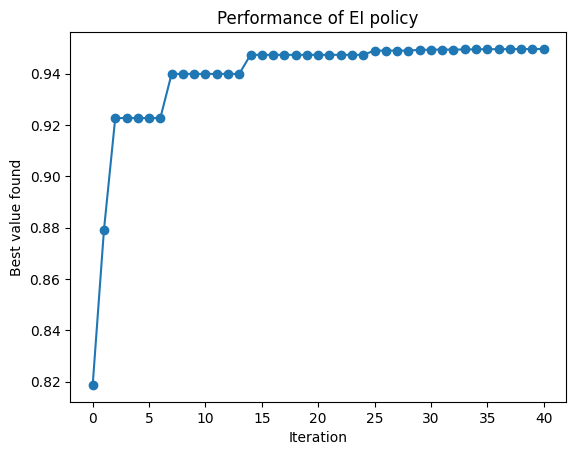

In [115]:
import matplotlib.pyplot as plt

plt.plot(EI_best,'o-')
plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.title("Performance of EI policy")

In [116]:
GI_best_dict = {}

In [120]:
def test_Gittins(seed, num_dimensions, maximize, cost, num_iterations, GI_best_dict):
    
    torch.manual_seed(seed)
    
    d = num_dimensions
    
    # Define the bounds of your d-dimensional hypercube
    lower_bounds = torch.zeros(d)
    upper_bounds = torch.ones(d)

    # Define the bounds of your cube (e.g., a unit cube in 3D space)
    bounds = torch.stack([lower_bounds, upper_bounds])

    # Number of points to sample
    n_points = 2*d+1

    # Generate points using Sobol sequences
    x = draw_sobol_samples(bounds=bounds, n=1, q=n_points, seed=seed).squeeze(0).requires_grad_(True)
    y = objective(x).unsqueeze(-1)  # add output dimension

    if maximize:
        best_f = y.max().item() 
    else:
        best_f = y.min().item() 

    GI_best = [best_f] # This will store the best value

    for i in range(num_iterations):

        # Fit the model
    #     with torch.no_grad():  # Temporarily set all the requires_grad flags to false
        model = fit_gp_model(x.detach(), y.detach(), Yvar=None)

        # Optimize GI
        GI = GittinsIndex(model=model, cost=cost, maximize=maximize)
        if maximize:
            new_point, new_point_GI = optimize_acqf(
                acq_function=GI,
                bounds=bounds,
                q=1,
                num_restarts=10*d,
                raw_samples=100*d,
                options={'method': 'L-BFGS-B'},
            )
        else:
            neg_GI = lambda X: -GI(X)
            new_point, new_point_neg_GI = optimize_acqf(
                acq_function=neg_GI,
                bounds=bounds,
                q=1,
                num_restarts=10*d,
                raw_samples=100*d,
                options={'method': 'L-BFGS-B'},
            )
            new_point_GI = -new_point_neg_GI

        new_value = objective(new_point)

        print("Iteration:", i)
        print("new point:", new_point.detach().numpy())
        print("new value:", new_value.item())

        #cross_validation(x,y,nu=0.5)


        # Add the new data
        x = torch.cat((x,new_point))
        y = torch.cat((y,new_value.unsqueeze(-1)))

        if maximize:
            best_f = max(best_f, new_value.item())
        else:
            best_f = min(best_f, new_value.item())

        GI_best.append(best_f)
        print("best oberved value:", best_f)
        print()
        
    GI_best_dict[cost] = GI_best

In [121]:
cost = 0.01
maximize = True
num_dimensions = 4
test_Gittins(seed=seed, num_dimensions=num_dimensions, maximize=maximize, cost=cost, num_iterations=num_iterations, GI_best_dict=GI_best_dict)

Iteration: 0
new point: [[0.06461016 0.52558626 0.92494841 0.53478245]]
new value: 0.8408142081285304
best oberved value: 0.8408142081285304

Iteration: 1
new point: [[0.19616217 0.81872624 1.         0.42130382]]
new value: 0.8771748650145954
best oberved value: 0.8771748650145954

Iteration: 2
new point: [[0.         0.7440532  1.         0.13050263]]
new value: 0.7691687515128327
best oberved value: 0.8771748650145954

Iteration: 3
new point: [[0.29631424 0.57079797 1.         0.45967362]]
new value: 0.8470923740741652
best oberved value: 0.8771748650145954

Iteration: 4
new point: [[0.19730147 0.71800266 0.89780514 0.49779929]]
new value: 0.877566049199513
best oberved value: 0.877566049199513

Iteration: 5
new point: [[0.17574603 0.67929606 0.96326239 0.38574475]]
new value: 0.9453400750809343
best oberved value: 0.9453400750809343

Iteration: 6
new point: [[0.15055337 0.63061342 1.         0.34346854]]
new value: 0.9404714168848547
best oberved value: 0.9453400750809343

Iteratio

In [123]:
cost=0.02
maximize = True
num_dimensions = 4
test_Gittins(seed=seed, num_dimensions=num_dimensions, maximize=maximize, cost=cost, num_iterations=num_iterations, GI_best_dict=GI_best_dict)

Iteration: 0
new point: [[0.08628167 0.56097026 0.90631093 0.50585204]]
new value: 0.8618444283501159
best oberved value: 0.8618444283501159

Iteration: 1
new point: [[0.14956179 0.77704286 1.         0.36067478]]
new value: 0.9228330443141353
best oberved value: 0.9228330443141353

Iteration: 2
new point: [[0.         0.71021898 1.         0.16341955]]
new value: 0.7819170546860674
best oberved value: 0.9228330443141353

Iteration: 3
new point: [[0.2748519  0.72562745 1.         0.51951337]]
new value: 0.8157838737643893
best oberved value: 0.9228330443141353

Iteration: 4
new point: [[0.13383691 0.77193062 0.92614981 0.38194637]]
new value: 0.9126366441318623
best oberved value: 0.9228330443141353

Iteration: 5
new point: [[0.14496605 0.72380676 0.99595778 0.36276742]]
new value: 0.9334363390432746
best oberved value: 0.9334363390432746

Iteration: 6
new point: [[0.14620805 0.69770309 1.         0.3592913 ]]
new value: 0.937551271832974
best oberved value: 0.937551271832974

Iteratio

In [124]:
cost=0.005
maximize = True
num_dimensions = 4
test_Gittins(seed=seed, num_dimensions=num_dimensions, maximize=maximize, cost=cost, num_iterations=num_iterations, GI_best_dict=GI_best_dict)

Iteration: 0
new point: [[0.0455054  0.49609834 0.93899973 0.55458465]]
new value: 0.8218275950469432
best oberved value: 0.8218275950469432

Iteration: 1
new point: [[0.        0.790039  1.        0.1573065]]
new value: 0.8019941973666821
best oberved value: 0.8218275950469432

Iteration: 2
new point: [[0.27745475 0.80606133 1.         0.52321456]]
new value: 0.7929060230522497
best oberved value: 0.8218275950469432

Iteration: 3
new point: [[0.09331201 0.34529057 1.         0.06003012]]
new value: 0.627242009176348
best oberved value: 0.8218275950469432

Iteration: 4
new point: [[0.0579169  0.69636408 0.85975332 0.41754018]]
new value: 0.8384304658929361
best oberved value: 0.8384304658929361

Iteration: 5
new point: [[0.23969557 0.9953516  0.87625754 0.02586648]]
new value: 0.8090728096398251
best oberved value: 0.8384304658929361

Iteration: 6
new point: [[0.00153683 0.22700214 0.81537941 1.        ]]
new value: 0.6627778849662846
best oberved value: 0.8384304658929361

Iteration: 

In [125]:
cost=0.002
maximize = True
num_dimensions = 4
test_Gittins(seed=seed, num_dimensions=num_dimensions, maximize=maximize, cost=cost, num_iterations=num_iterations, GI_best_dict=GI_best_dict)

Iteration: 0
new point: [[0.02363114 0.46383    0.95330741 0.57320453]]
new value: 0.8027909720768016
best oberved value: 0.8187104648069814

Iteration: 1
new point: [[0.         0.83837702 1.         0.12225413]]
new value: 0.7874273758271987
best oberved value: 0.8187104648069814

Iteration: 2
new point: [[0.29869284 0.8332776  1.         0.55665277]]
new value: 0.7806858825456116
best oberved value: 0.8187104648069814

Iteration: 3
new point: [[0.03952414 0.28929335 1.         0.        ]]
new value: 0.5734400532957786
best oberved value: 0.8187104648069814

Iteration: 4
new point: [[0.0474658  0.70860898 0.88856561 0.43855046]]
new value: 0.8398464481681501
best oberved value: 0.8398464481681501

Iteration: 5
new point: [[0.31479848 1.         0.89876942 0.        ]]
new value: 0.82350006291879
best oberved value: 0.8398464481681501

Iteration: 6
new point: [[0.         0.12324348 0.75800245 1.        ]]
new value: 0.6494822303240232
best oberved value: 0.8398464481681501

Iteratio

In [126]:
cost=0.001
maximize = True
num_dimensions = 4
test_Gittins(seed=seed, num_dimensions=num_dimensions, maximize=maximize, cost=cost, num_iterations=num_iterations, GI_best_dict=GI_best_dict)

Iteration: 0
new point: [[0.0092009  0.4432962  0.96206068 0.58383287]]
new value: 0.7926430856131348
best oberved value: 0.8187104648069814

Iteration: 1
new point: [[0.         0.87136843 1.         0.08785188]]
new value: 0.7666448134714295
best oberved value: 0.8187104648069814

Iteration: 2
new point: [[0.31122227 0.8442481  1.         0.5821905 ]]
new value: 0.7762412036461748
best oberved value: 0.8187104648069814

Iteration: 3
new point: [[0.02919258 0.23970393 1.         0.        ]]
new value: 0.5608244428414637
best oberved value: 0.8187104648069814

Iteration: 4
new point: [[0.         0.76966028 1.         1.        ]]
new value: 0.655849671867888
best oberved value: 0.8187104648069814

Iteration: 5
new point: [[0.40562856 1.         0.97407675 0.        ]]
new value: 0.8642199680769316
best oberved value: 0.8642199680769316

Iteration: 6
new point: [[0.23717965 1.         0.73843524 0.        ]]
new value: 0.7043023121210085
best oberved value: 0.8642199680769316

Iterati

Text(0.5, 1.0, 'Performance of EI policy vs Gittins policy')

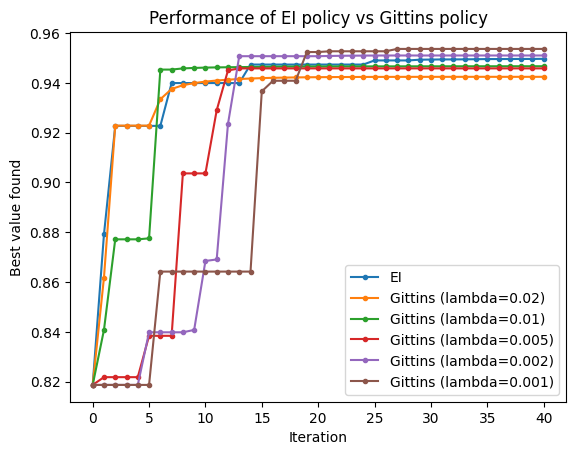

In [127]:
# Plotting EI
plt.plot(EI_best, '.-', label='EI')

# Plotting Gittins
for cost in sorted(GI_best_dict.keys(), reverse=True):
    label = "Gittins (lambda={})".format(cost)
    plt.plot(GI_best_dict[cost], '.-', label=label)

# Adding legend
plt.legend()

plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.title("Performance of EI policy vs Gittins policy")